In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

In [24]:
def extract_seed_pixels(stroke_image_array, image_array):
    """Function to extract seed pixels from stroke_image_array and image_array."""
    blue =np.array([255, 0, 6]) # BGR
    red =np.array([0, 0, 255]) # BGR
    
    # Initialize numpy arrays for blue and red pixels (2D arrays)
    blue_pixels=np.empty((0,3))
    red_pixels=np.empty((0,3))
    
    # 2D arrays with same width and height as stroke_image indicating blue and red pixels
    blue_indices = np.all(stroke_image_array == blue, axis=-1)
    red_indices = np.all(stroke_image_array == red, axis=-1)

    # Use the above indices to extract corresponding pixels from image_array
    blue_pixels = image_array[blue_indices]
    red_pixels = image_array[red_indices]
    
    # 2D arrays with shape (n,3)
    return red_pixels, blue_pixels
 


In [25]:
def weight(index):
    """Calculate the weight of each pixel in the image."""
    uniqueq, counts = np.unique(index, return_counts=True)
    # return the relative frequency of each unique value in the index array
    return counts / len(index)  

In [26]:
def calc_prob(image, f_centroids, f_indices, b_centroids, b_indices):
    """Calculate the probability of each pixel in the image belonging to foreground or background."""
    fg_weight = weight(f_indices)
    bg_weight = weight(b_indices)

    # Reshape the image array to 2D for broadcasting (n, 3)
    reshaped_img = image.reshape(-1, 3)

    # Calculate foreground probabilities
    fg_distances = np.linalg.norm(reshaped_img[:, np.newaxis] - f_centroids, axis=2)
    fg_probabilities = np.sum(fg_weight * np.exp(-fg_distances), axis=1)

    # Calculate background probabilities
    bg_distances = np.linalg.norm(reshaped_img[:, np.newaxis] - b_centroids, axis=2)
    bg_probabilites = np.sum(bg_weight * np.exp(-bg_distances), axis=1)

    # Assign pixels to foreground or background based on higher probability
    binary_weights = np.where(fg_probabilities > bg_probabilites, 255, 0)

    # Reshape the result back to the original image shape
    binary_weights = binary_weights.reshape(image.shape[:2])
    return binary_weights

In [27]:
def mydisplay(bw, image):
    # Create a 3D mask from the 2D bw array
    mask = np.stack([bw]*3, axis=-1)

    # Create the images by applying the mask
    fg_image_array = np.where(mask, image, 0)
    bg_image_array = np.where(mask, 0, image)

    # Convert the images to RGB
    dst = cv2.cvtColor(fg_image_array, cv2.COLOR_BGR2RGB)
    dst1 = cv2.cvtColor(bg_image_array, cv2.COLOR_BGR2RGB)
    dst2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

    # Display each image on a separate subplot
    axs[0].imshow(dst2)
    axs[1].imshow(dst)
    axs[2].imshow(dst1)
    plt.show()

    return dst2, dst, dst1


In [28]:
from kmeans import KMeans


def lazySnapping(image_array, seed_image_array, k):
    """The main function to perform all steps of lazy snapping."""
    #initialize the kmeans object
    kmeanalgo = KMeans(k = 3)
    
    start_time = time.time()
    
    # Step 1) Extract seed pixels
    # fg_pixels ,bg_pixels = extract_seed_pixels(seed_image_array ,image_array)
    # print(fg_pixels.shape)
    seed_image_array = seed_image_array.reshape(-1, 3)
    kmeanalgo.fit(seed_image_array) # fit the seed image array
    seed_centroids = kmeanalgo.centroids # get the centroids
    seed_indices = kmeanalgo.predict(seed_image_array) # get the indices
    # seed_indices = seed_indices.reshape(image_array.shape[:2]) # reshape the indices to the original image shape
    unique, counts = np.unique(seed_indices, return_counts=True)
    
    unique = np.delete(unique, np.argmax(counts))
    
    print((seed_indices == unique[0]).shape)
    print(seed_indices == unique[0])
    
    fg_pixels = image_array[seed_indices == unique[0]]
    bg_pixels = image_array[seed_indices == unique[1]]
    
    print(unique, counts)
    print(seed_centroids.shape)
    print(seed_centroids[np.argmax(counts)])
    print(seed_indices.shape)
    print(seed_indices)
    Step 2) Perform k-means clustering on foreground and background pixels
    kmeanalgo.fit(fg_pixels)
    fg_centroids = kmeanalgo.centroids
    fg_indices = kmeanalgo.predict(fg_pixels)
    
    kmeanalgo.fit(bg_pixels)
    bg_centroids = kmeanalgo.centroids
    bg_indices = kmeanalgo.predict(bg_pixels)
    
    # Step 3) Calculate the probability of each pixel in the image belonging to foreground or background
    bin_weight_mask = calc_prob(image_array, fg_centroids, fg_indices, bg_centroids, bg_indices)
    
    # Step 4) Display the results
    img, fog, bag = mydisplay(bin_weight_mask, image_array)
    
    end_time = time.time()
    
    print('Process time:')
    print(f'{end_time - start_time:.4f}s ({(end_time - start_time) / 60:.3f} minutes)')
    return fog,bag
    

SyntaxError: unmatched ')' (723486671.py, line 34)

In [ ]:
# Test dataset 1
lady_seed_1 = cv2.imread('data/lady stroke 1.png', cv2.IMREAD_UNCHANGED)
lady_seed_2 = cv2.imread('data/lady stroke 2.png', cv2.IMREAD_UNCHANGED)
lady = cv2.imread('data/lady.PNG')

# Test dataset 2
mona_seed_1 = cv2.imread('data/Mona-lisa stroke 1.png', cv2.IMREAD_UNCHANGED)
mona_seed_2 = cv2.imread('data/Mona-lisa stroke 2.png', cv2.IMREAD_UNCHANGED)
mona = cv2.imread('data/Mona-lisa.PNG')

# Test dataset 3
van_seed = cv2.imread('data/van Gogh stroke.png', cv2.IMREAD_UNCHANGED)
van = cv2.imread('data/van Gogh.PNG')




(480, 323)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


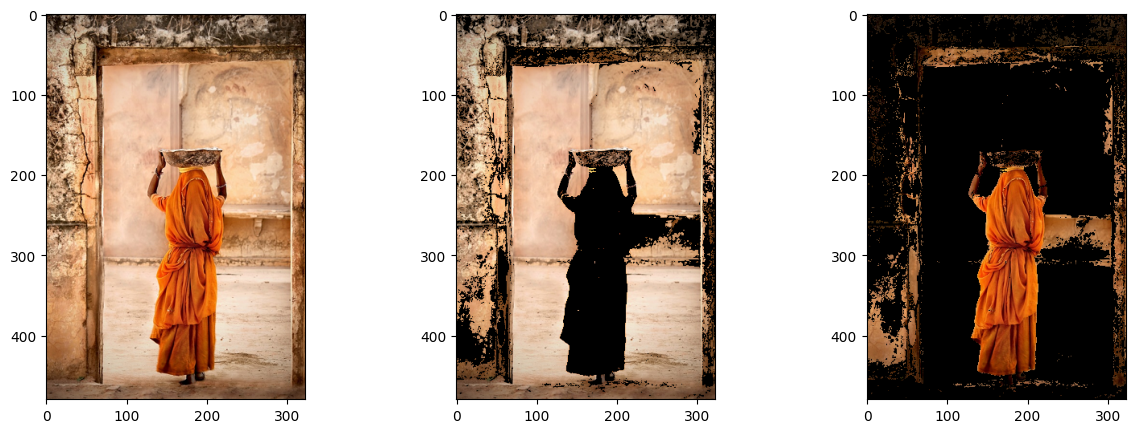

Process time:
0.4546s (0.008 minutes)
(480, 323)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


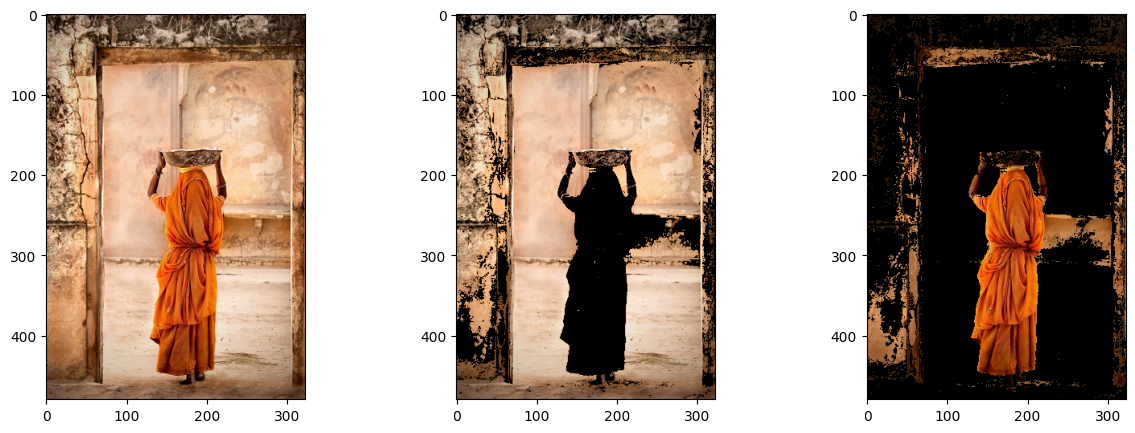

Process time:
0.5369s (0.009 minutes)
(414, 431)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


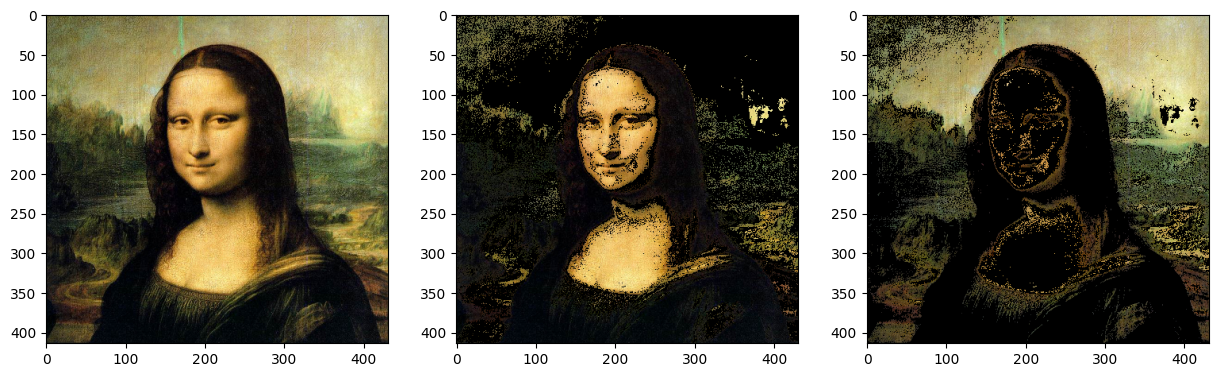

Process time:
0.5721s (0.010 minutes)
(414, 431)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


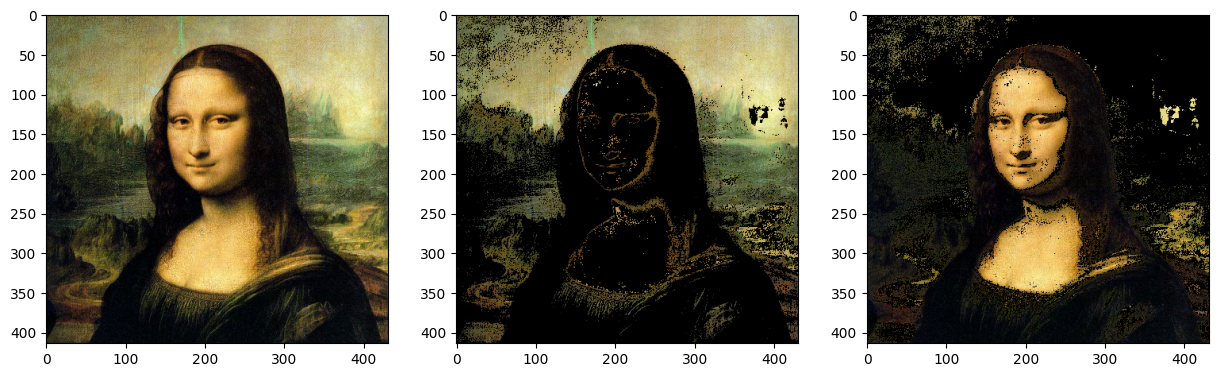

Process time:
0.5452s (0.009 minutes)


ValueError: cannot reshape array of size 273240 into shape (495,414)

In [ ]:

# lazySnapping(lady, lady_seed_1, 64)
# lazySnapping(lady, lady_seed_2, 64)

# lazySnapping(mona, mona_seed_1, 64)
# lazySnapping(mona, mona_seed_2, 64)

lazySnapping(van, van_seed, 64)



